In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = [8, 5]
sns.set_style('whitegrid', {'axes.labelcolor': '0', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

## NPHET IEMAG 2021-07-09 Model Scenario Projections vs Reported Data

This notebook compares the NPHET IEMAG 2021-07-09 model scenario projections with reported data, for 2021-07-01 to 2021-09-30. The projections are the mean values from the [Slides from the NPHET press briefing - Wednesday 14 July 2021](https://assets.gov.ie/154104/6a7feada-ea10-4f27-98b8-e8b5dc31771d.pdf).

Note:
* Daily data are currently not provided for deaths. These will be included when they are available again.

Slide 14 Summary:

<img src="figures/20210714_nphet_slides_summary_slide14.png" width="60%">

Slide 12 - Optimistic Scenario - Accelerated Vaccination (AV):

<img src="figures/20210714_nphet_slides_optimisticav_monthly.png" width="60%">



### Load the reported case data

This is a daily snapshot of the following from [Ireland's COVID-19 Data Hub](https://covid-19.geohive.ie/):
* [Covid-19 Daily Statistics](https://covid-19.geohive.ie/datasets/d8eb52d56273413b84b0187a4e9117be_0/explore?location=53.385818%2C-8.057012%2C7.64&showTable=true)
* [Acute Hospitals Confirmed Cases (New) and Admissions to ICU](https://covid-19.geohive.ie/pages/hospitals-icu--testing)

In [3]:
reporteddf = pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
reporteddf = reporteddf[reporteddf.Date>='2021-07-01']
reporteddf.Cases = reporteddf.Cases.cumsum()
reporteddf.HospitalCases = reporteddf.HospitalCases.cumsum()
reporteddf.IcuCases = reporteddf.IcuCases.cumsum()
reporteddf['Scenario'] = 'Reported'

### Scenario data 2021-07-01 to 2021-09-30, based on Table 1 and monthly tables above

In [4]:
scenario_dates = pd.date_range('2021-07-01', '2021-09-30')
july_dates = pd.date_range('2021-07-01', '2021-07-31')
august_dates = pd.date_range('2021-08-01', '2021-08-31')
september_dates = pd.date_range('2021-09-01', '2021-09-30')

@dataclass(frozen=True)
class Scenario:
    name: str
    mean_cases: int
    mean_hospital_cases: int
    mean_icu_cases: int
    dates: pd.DatetimeIndex
    color: int
  
# No monthly data yet for Central 1, Central 2, Pessimistic scenarios
scenarios = {name: Scenario(name, mean_cases, mean_hospital_cases, mean_icu_cases, dates, color) for name, mean_cases, mean_hospital_cases, mean_icu_cases, dates, color in 
    [
        ('Minimal change', 62000, 1185, 160, scenario_dates, 0),
        ('Optimistic-AV (Jul)', 15000, 270, 35, july_dates, 6),
        ('Optimistic-AV (Aug)', 15000+33000, 270+590, 35+75, august_dates, 7),
        ('Optimistic-AV (Sep)', 105000, 1985, 260, september_dates, 1),
        ('Optimistic-AV', 105000, 1985, 260, scenario_dates, 1),
        #('Central 1 (Jul)', 10000, 180, 25, july_dates, 6),
        #('Central 1 (Aug)', 10000+46000, 180+790, 25+95, august_dates, 7),
        #('Central 1 (Sep)', 187000, 3490, 450, september_dates, 2),
        ('Central 1', 185000, 3455, 445, scenario_dates, 2),
        #('Central 2 (Jul)', 16000, 280, 35, july_dates, 6),
        #('Central 2 (Aug)', 16000+106000, 280+1790, 35+210, august_dates, 7),
        #('Central 2 (Sep)', 408000, 7690, 985, september_dates, 3),
        ('Central 2', 379000, 6505, 915, scenario_dates, 3),
        #('Pessimistic (Jul)', 20000, 325, 40, july_dates, 6),
        #('Pessimistic (Aug)', 197000+23000, 325+3310, 40+385, august_dates, 7),
        #('Pessimistic (Sep)', 681000, 12985, 1685, september_dates, 4),
        ('Pessimistic', 566000, 10730, 1390, scenario_dates, 4),
    ]
}

scenariodf = pd.DataFrame({'Date': np.concatenate([x.dates for x in scenarios.values()]), 
                           'Scenario': np.concatenate([[x] * len(y.dates) for x, y in scenarios.items()]), 
                           'Cases': np.concatenate([[x.mean_cases] * len(x.dates) for x in scenarios.values()]),
                           'HospitalCases': np.concatenate([[x.mean_hospital_cases] * len(x.dates) for x in scenarios.values()]),
                           'IcuCases': np.concatenate([[x.mean_icu_cases] * len(x.dates) for x in scenarios.values()])})

### NPHET scenarios vs reported cases

In [5]:
default_palette = sns.color_palette()
generate_dashes = lambda plot_scenarios:[(3,2)] * len(plot_scenarios) + ['']
generate_palette = lambda plot_scenarios:[default_palette[scenarios[x].color] for x in plot_scenarios] + [default_palette[5]]

def plot_cases(plot_scenarios, model_title, case_type='', y='Cases', ylabel='Cases', legend_loc='upper left', filename=None):
    ax = sns.lineplot(data=pd.concat((scenariodf[scenariodf.Scenario.isin(plot_scenarios)], reporteddf), ignore_index=True), x='Date', y=y, hue='Scenario', style='Scenario', dashes=generate_dashes(plot_scenarios), palette=generate_palette(plot_scenarios))
    sns.despine(left=True, bottom=True)
    ax.set_title(f'NPHET IEMAG 2021-07-09 {model_title} Scenarios vs Reported {case_type}Cases (Cumulative)')
    ax.set_ylabel(ylabel)
    plt.legend(loc=legend_loc)
    plt.xticks(rotation=30);
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        
def plot_hospital_cases(plot_scenarios, model_title, legend_loc='upper left', filename=None):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Hospital ', 
               y='HospitalCases', 
               ylabel='New Hospital Cases',
               legend_loc=legend_loc, 
               filename=filename)
    
def plot_icu_cases(plot_scenarios, model_title, legend_loc='upper left', filename=None):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='ICU ', 
               y='IcuCases', 
               ylabel='New ICU Cases',
               legend_loc=legend_loc, 
               filename=filename)

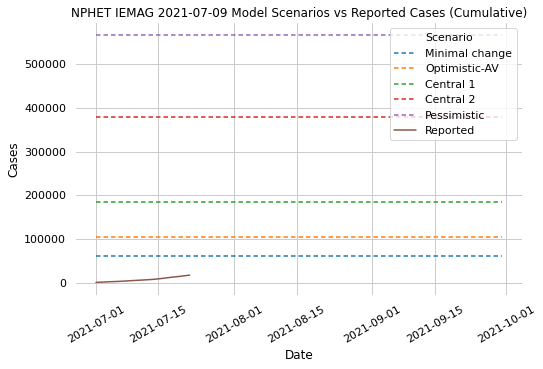

In [6]:
plot_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
           model_title='Model', 
           legend_loc='upper right',
           filename='./figures/nphet20210709_all_scenarios_vs_reported_cases.png')

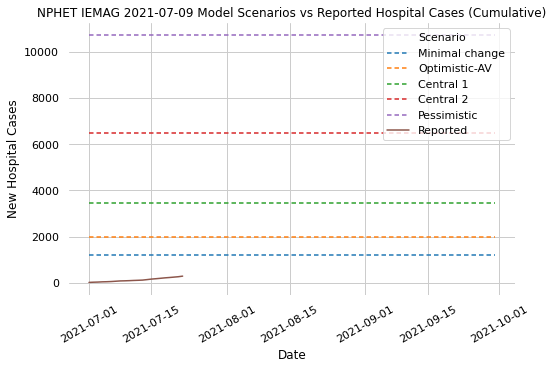

In [7]:
plot_hospital_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
                    model_title='Model', 
                    legend_loc='upper right',
                    filename='./figures/nphet20210709_all_scenarios_vs_reported_hospital_cases.png')

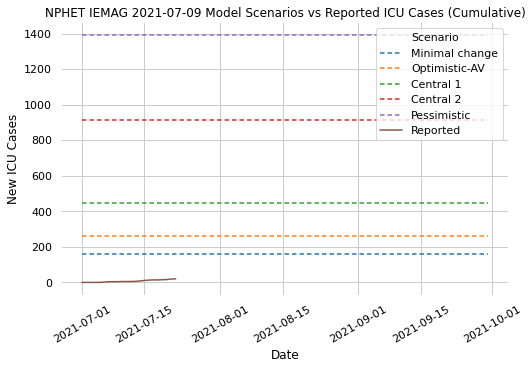

In [8]:
plot_icu_cases(plot_scenarios=['Minimal change', 'Optimistic-AV', 'Central 1', 'Central 2', 'Pessimistic'], 
               model_title='Model', 
               legend_loc='upper right',
               filename='./figures/nphet20210709_all_scenarios_vs_reported_icu_cases.png')

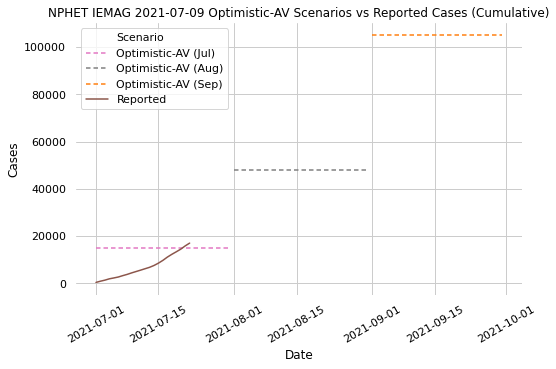

In [9]:
plot_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
           model_title='Optimistic-AV',
           filename='./figures/nphet20210709_optimisticav_scenarios_vs_reported_cases.png')

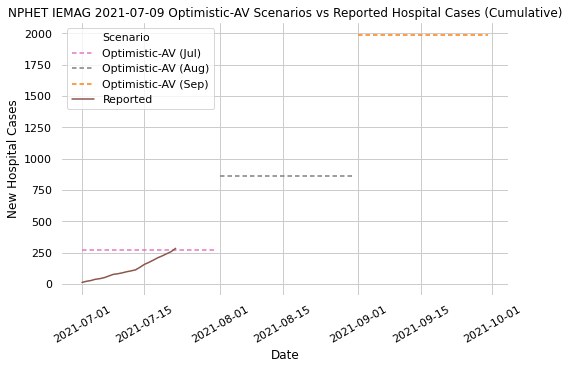

In [10]:
plot_hospital_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
                    model_title='Optimistic-AV',
                    filename='./figures/nphet20210709_optimistic_scenarios_vs_reported_hospital_cases.png')

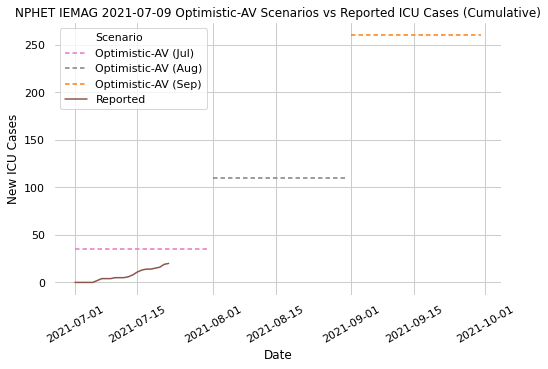

In [11]:
plot_icu_cases(plot_scenarios=['Optimistic-AV (Jul)', 'Optimistic-AV (Aug)', 'Optimistic-AV (Sep)'], 
               model_title='Optimistic-AV',
               filename='./figures/nphet20210709_optimistic_scenarios_vs_reported_icu_cases.png')

In [12]:
#plot_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#           model_title='Central 1',
#           filename='./figures/nphet20210709_central1_scenarios_vs_reported_cases.png')

In [13]:
#plot_hospital_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#                    model_title='Central 1',
#                    filename='./figures/nphet20210709_central1_scenarios_vs_reported_hospital_cases.png')

In [14]:
#plot_icu_cases(plot_scenarios=['Central 1 (Jul)', 'Central 1 (Aug)', 'Central 1 (Sep)'], 
#               model_title='Central 1',
#               filename='./figures/nphet20210709_central1_scenarios_vs_reported_icu_cases.png')

In [15]:
#plot_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#           model_title='Central 2',
#           filename='./figures/nphet20210709_central2_scenarios_vs_reported_cases.png')

In [16]:
#plot_hospital_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#                    model_title='Central 2',
#                    filename='./figures/nphet20210709_central2_scenarios_vs_reported_hospital_cases.png')

In [17]:
#plot_icu_cases(plot_scenarios=['Central 2 (Jul)', 'Central 2 (Aug)', 'Central 2 (Sep)'], 
#               model_title='Central 2',
#               filename='./figures/nphet20210709_central2_scenarios_vs_reported_icu_cases.png')

In [18]:
#plot_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#           model_title='Pessimistic',
#           filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_cases.png')

In [19]:
#plot_hospital_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#                    model_title='Pessimistic',
#                    filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_hospital_cases.png')

In [20]:
#plot_icu_cases(plot_scenarios=['Pessimistic (Jul)', 'Pessimistic (Aug)', 'Pessimistic (Sep)'], 
#               model_title='Pessimistic',
#               filename='./figures/nphet20210709_pessimistic_scenarios_vs_reported_icu_cases.png')

### Generate current cases/hospitalisation/ICU summaries

In [21]:
def generate_summary(reported_column, scenario_cases, title):
    num_reported_days = len(reporteddf)
    scenario_length = len(scenario_dates)
    cases_current_row = reporteddf.iloc[-1]
    cases_current = cases_current_row[reported_column]
    cases_previous = reporteddf.iloc[-2][reported_column]
    new_cases = cases_current - cases_previous
    scenario_status = {}
    print(f"""NPHET IEMAG 2021-07-09 Model Scenarios vs Reported {title}

({datetime.strftime(cases_current_row.Date, "%A %Y-%m-%d")})

- Reported Total: {cases_current} (+{new_cases})
- % Scenario Duration ({len(scenario_dates)} days): {num_reported_days*100/scenario_length:.1f}%""")

    for scenario in ['Optimistic-AV (Jul)', 'Optimistic-AV (Sep)']:
        mean_cases = getattr(scenarios[scenario], scenario_cases)
        cases_current_perc = cases_current*100/mean_cases
        scenario_status[scenario] = {
            'cases_current_perc': cases_current_perc,
            'mean_daily_required_cases': (mean_cases - cases_current)/(scenario_length - num_reported_days)
        }
        print(f'- % {scenario} Scenario Total: {cases_current_perc:.1f}% (+{new_cases*100/mean_cases:.1f}%)')
    return scenario_status

In [22]:
cases_status = generate_summary('Cases', 'mean_cases', 'Cases')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported Cases

(Thursday 2021-07-22)

- Reported Total: 17078 (+1189)
- % Scenario Duration (92 days): 23.9%
- % Optimistic-AV (Jul) Scenario Total: 113.9% (+7.9%)
- % Optimistic-AV (Sep) Scenario Total: 16.3% (+1.1%)


In [23]:
hosp_status = generate_summary('HospitalCases', 'mean_hospital_cases', 'New HOSPITAL Cases')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported New HOSPITAL Cases

(Thursday 2021-07-22)

- Reported Total: 284 (+26)
- % Scenario Duration (92 days): 23.9%
- % Optimistic-AV (Jul) Scenario Total: 105.2% (+9.6%)
- % Optimistic-AV (Sep) Scenario Total: 14.3% (+1.3%)


In [24]:
icu_status = generate_summary('IcuCases', 'mean_icu_cases', 'New ICU Cases')

NPHET IEMAG 2021-07-09 Model Scenarios vs Reported New ICU Cases

(Thursday 2021-07-22)

- Reported Total: 20 (+1)
- % Scenario Duration (92 days): 23.9%
- % Optimistic-AV (Jul) Scenario Total: 57.1% (+2.9%)
- % Optimistic-AV (Sep) Scenario Total: 7.7% (+0.4%)


In [25]:
status_scenario = 'Optimistic-AV (Sep)'

print(f"""As of today ({datetime.strftime(reporteddf.iloc[-1].Date, "%Y-%m-%d")}), the following have been reported for the Optimistic-AV scenario:

- {cases_status[status_scenario]['cases_current_perc']:.1f}% cases
- {hosp_status[status_scenario]['cases_current_perc']:.1f}% hospitalisation
- {icu_status[status_scenario]['cases_current_perc']:.1f}% ICU cases

Average daily numbers required until end Sept to reach the Optimistic-AV projection totals:

- {cases_status[status_scenario]['mean_daily_required_cases']:.0f} cases
- {hosp_status[status_scenario]['mean_daily_required_cases']:.0f} hosp
- {icu_status[status_scenario]['mean_daily_required_cases']:.0f} ICU
""")

As of today (2021-07-22), the following have been reported for the Optimistic-AV scenario:

- 16.3% cases
- 14.3% hospitalisation
- 7.7% ICU cases

Average daily numbers required until end Sept to reach the Optimistic-AV projection totals:

- 1256 cases
- 24 hosp
- 3 ICU

